# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



**System Versions**
```bash
Python==3.10.6

pip install -q pandas==1.5.1 -U
pip install -q numpy==1.23.4 -U
pip install -q matplotlib==3.6.0 -U
pip install -q seaborn==0.12.1 -U
pip install -q tensorflow==2.10.0 -U
pip install -q scikit-learn==1.1.2 -U
pip install -q nltk==3.7 -U
pip install -q tqdm==4.64.1 -U
pip install -q keras==2.10.0 -U
pip install -q logging==0.5.1.2 -U
```

**Kaggle Versions**
```bash
pip install -q pandas==1.3.5 -U
pip install -q numpy==1.21.6 -U
pip install -q matplotlib==3.5.3 -U
pip install -q seaborn==0.11.2 -U
pip install -q tensorflow==2.6.4 -U
pip install -q scikit-learn==1.0.2 -U
pip install -q nltk==3.7 -U
pip install -q tqdm==4.64.0 -U
pip install -q keras==2.6.0 -U
pip install -q logging==0.5.1.2 -U
```

In [1]:
%%bash
rm -r *
mkdir -p raw_data
wget -qO raw_data/ita-eng.zip http://www.manythings.org/anki/ita-eng.zip 
wget -qO raw_data/glove.6B.100d.txt https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
unzip -q raw_data/ita-eng.zip -d raw_data/

tree

.
└── raw_data
    ├── _about.txt
    ├── glove.6B.100d.txt
    ├── ita-eng.zip
    └── ita.txt

1 directory, 4 files


<font color='blue'>**Load the data**</font>

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import re
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding

from tensorflow.nn import tanh
from tensorflow.nn import softmax
from tensorflow import reduce_sum
from tensorflow import expand_dims
from tensorflow.keras.layers import Dot

import nltk.translate.bleu_score as bleu

# from tensorflow.keras.utils import pad_sequences
from keras.preprocessing.sequence import pad_sequences # KAGGLE Version

from nltk.translate.bleu_score import sentence_bleu

tqdm.pandas()
plt.style.use('fivethirtyeight')

import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('raw_data/ita.txt', 'r') as file:
    
    eng, ita = [], []
    
    for line in file.readlines():
        eng.append(line.split('\t')[0].strip())
        ita.append(line.split('\t')[1].strip())

data = pd.DataFrame({'english' : eng, 'italian' : ita})
print(f'Shape of data frame :: {data.shape}')
data.head()

Shape of data frame :: (358373, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [4]:
data.tail()

,english,italian
358368,I know that adding sentences only in your nati...,So che aggiungere frasi soltanto nella sua lin...
358369,I know that adding sentences only in your nati...,So che aggiungere frasi solamente nella sua li...
358370,I know that adding sentences only in your nati...,So che aggiungere frasi solamente nella sua li...
358371,Doubtless there exists in this world precisely...,Senza dubbio esiste in questo mondo proprio la...
358372,Doubtless there exists in this world precisely...,Senza dubbio esiste in questo mondo proprio la...


<font color='blue'>**Preprocess data**</font>

In [5]:
def decontractions(phrase):
    
    # https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
    # decontracted takes text and convert contractions into natural form.
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    
    # https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # convert all the text into lower letters
    # remove all the spacial characters: except space ' '
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].progress_apply(preprocess)
data['italian'] = data['italian'].progress_apply(preprocess_ita)
data.head()

100%|██████████| 358373/358373 [00:09<00:00, 38626.95it/s]


,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [6]:
ita_lengths = data['italian'].str.split().progress_apply(len)
eng_lengths = data['english'].str.split().progress_apply(len)

100%|██████████| 358373/358373 [00:00<00:00, 933077.48it/s] 


**Analysis on Ennglish sentence length**

In [7]:
print('Percentile : 0 - 100'); print('-' * 20)
for i in range(0,101,10):
    print(f'{i:3d} : {np.percentile(eng_lengths, i)}')

print('\nPercentile : 90 - 100'); print('-' * 20)
for i in range(90,101):
    print(f'{i:3d} : {np.percentile(eng_lengths, i)}')
    
print('\nPercentile : 99 - 100'); print('-' * 20)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(f'{i} : {np.percentile(eng_lengths, i)}')

Percentile : 0 - 100
--------------------
  0 : 1.0
 10 : 4.0
 20 : 4.0
 30 : 5.0
 40 : 5.0
 50 : 6.0
 60 : 6.0
 70 : 7.0
 80 : 7.0
 90 : 8.0
100 : 101.0

Percentile : 90 - 100
--------------------
 90 : 8.0
 91 : 9.0
 92 : 9.0
 93 : 9.0
 94 : 9.0
 95 : 9.0
 96 : 10.0
 97 : 10.0
 98 : 11.0
 99 : 12.0
100 : 101.0

Percentile : 99 - 100
--------------------
99.1 : 12.0
99.2 : 13.0
99.3 : 13.0
99.4 : 13.0
99.5 : 14.0
99.6 : 14.0
99.7 : 15.0
99.8 : 16.0
99.9 : 25.0
100 : 101.0


**Analysis on Italian sentence length**

In [8]:
print('Percentile : 0 - 100'); print('-' * 20)
for i in range(0,101,10):
    print(f'{i:3d} : {np.percentile(ita_lengths, i)}')

print('\nPercentile : 90 - 100'); print('-' * 20)
for i in range(90,101):
    print(f'{i:3d} : {np.percentile(ita_lengths, i)}')
    
print('\nPercentile : 99 - 100'); print('-' * 20)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(f'{i} : {np.percentile(ita_lengths, i)}')

Percentile : 0 - 100
--------------------
  0 : 1.0
 10 : 3.0
 20 : 4.0
 30 : 4.0
 40 : 5.0
 50 : 5.0
 60 : 6.0
 70 : 6.0
 80 : 7.0
 90 : 8.0
100 : 92.0

Percentile : 90 - 100
--------------------
 90 : 8.0
 91 : 8.0
 92 : 8.0
 93 : 9.0
 94 : 9.0
 95 : 9.0
 96 : 9.0
 97 : 10.0
 98 : 11.0
 99 : 12.0
100 : 92.0

Percentile : 99 - 100
--------------------
99.1 : 12.0
99.2 : 12.0
99.3 : 13.0
99.4 : 13.0
99.5 : 13.0
99.6 : 14.0
99.7 : 15.0
99.8 : 16.0
99.9 : 22.0
100 : 92.0


> <font color="blue"><b>If you observe the values, 99.9% of the data points are having length &lt; 20, so select the sentences that have words &lt; 20 </b> </font>
<br>
<br>
> <font color="green"><b>Inorder to do the teacher forcing while training of seq-seq models, lets create two new columns, one with  &lt;start&gt; token at begining of the sentence and other column with &lt;end&gt; token at the end of the sequence</b></font>

In [9]:
data['italian_len'] = data['italian'].str.split().progress_apply(len)
data = data[data['italian_len'] <= 20]

data['english_len'] = data['english'].str.split().progress_apply(len)
data = data[data['english_len'] <= 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)

# only for the first sentance add a toke <end> so that we will have <end> in tokenizer

data.head()

100%|██████████| 357956/357956 [00:00<00:00, 751496.38it/s]


,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [10]:
train, validation = train_test_split(data, test_size = 0.2, random_state = 45)

In [11]:
train.head()

,italian,english_inp,english_out
291747,ho bisogno di scoprire dove vive tom,<start> i need to find out where tom lives,i need to find out where tom lives <end>
340581,puoi permetterti di prendere le ferie questestate,<start> can you afford to take a holiday this ...,can you afford to take a holiday this summer <...
59340,non mi dare quella,<start> do not give me that,do not give me that <end>
13685,io non danzerò,<start> i will not dance,i will not dance <end>
348676,tom ha iniziato a trascorrere molto tempo con ...,<start> tom has started spending a lot of time...,tom has started spending a lot of time with ma...


In [12]:
print(f'Train Shape : {train.shape}\nValidation Shape : {validation.shape}')

# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output

train.iloc[0]['english_inp'] = str(train.iloc[0]['english_inp']) + ' <end>'
train.iloc[0]['english_out'] = str(train.iloc[0]['english_out']) + ' <end>'

Train Shape : (286329, 3)
Validation Shape : (71583, 3)


In [13]:
train.head()

,italian,english_inp,english_out
291747,ho bisogno di scoprire dove vive tom,<start> i need to find out where tom lives <end>,i need to find out where tom lives <end> <end>
340581,puoi permetterti di prendere le ferie questestate,<start> can you afford to take a holiday this ...,can you afford to take a holiday this summer <...
59340,non mi dare quella,<start> do not give me that,do not give me that <end>
13685,io non danzerò,<start> i will not dance,i will not dance <end>
348676,tom ha iniziato a trascorrere molto tempo con ...,<start> tom has started spending a lot of time...,tom has started spending a lot of time with ma...


In [14]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [15]:
vocab_size_eng = len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita = len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

13206
26862


In [16]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10389)

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [17]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,
                                encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size

        # Initialize Embedding layer
        self.embeding = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_size, \
                  input_length = self.input_length, mask_zero = True, name = 'EmbeddingLayerEncoder')
        
        # Intialize Encoder LSTM layer
        self.lstm = LSTM(units = self.lstm_size, return_state = True, \
                                                     return_sequences = True,  name = 'LSTM_Encoder')
        
    def call(self, input_sequence, states):
                         
        '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
        returns -- encoder_output, last time step's hidden and cell state
        '''
                         
        input_embeddings = self.embeding(input_sequence)
        self.encoder_output, self.encoder_last_state_h, self.encoder_last_state_c = \
                                                self.lstm(input_embeddings) #, initial_state = states)
        return self.encoder_output, self.encoder_last_state_h, self.encoder_last_state_c
    
    def initialize_states(self, batch_size):
                         
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units],
                                                            cell state zeros is of size [32,lstm_units]
        '''
                         
        self.st_h = tf.zeros((batch_size, self.lstm_size))
        self.st_i = tf.zeros((batch_size, self.lstm_size))
        
        return self.st_h, self.st_i

<font color='orange'>**Grader function - 1**</font>

In [18]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size = 10
    embedding_size = 20
    lstm_size = 32
    input_length = 10
    batch_size = 16
    
    #Intialzing encoder 
    encoder = Encoder(vocab_size, embedding_size, lstm_size, input_length)
    input_sequence = tf.random.uniform(shape = [batch_size, input_length], \
                                       maxval = vocab_size, minval = 0, dtype = tf.int32)
     
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and \
                   state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True

print(grader_check_encoder())

True


In [19]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self, out_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        
        
        self.out_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size
        
        # Initialize Embedding layer
        self.embeding = Embedding(input_dim = self.out_vocab_size, output_dim = self.embedding_size, \
                    input_length = self.input_length, mask_zero = True, name = 'EmbeddingLayerDecoder')
        
        # Intialize Decoder LSTM layer
        self.lstm = LSTM(units = self.lstm_size, return_state = True, return_sequences = True, \
                                                                                 name = 'LSTM_Decoder')

    def call(self, input_sequence, initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output, decoder_final_state_h, decoder_final_state_c
        '''

        input_embed = self.embeding(input_sequence)
        self.decoder_output, self.decoder_final_state_h, self.decoder_final_state_c = \
                                                    self.lstm(input_embed, initial_state = initial_states)

        return self.decoder_output, self.decoder_final_state_h, self.decoder_final_state_c

<font color='orange'>**Grader function - 2**</font>

In [20]:
def grader_decoder():
    
    '''
    out_vocab_size: Unique words of the target language,
    embedding_size: output embedding dimension for each word after embedding layer,
    dec_units: Number of lstm units in decoder,
    input_length: Length of the input sentence,
    batch_size
    '''
    
    out_vocab_size = 13 
    embedding_dim = 12 
    input_length = 10
    dec_units = 16 
    batch_size = 32
    
    target_sentences = tf.random.uniform(shape = (batch_size, input_length), maxval = 10, \
                                         minval = 0, dtype = tf.int32)
    
    encoder_output = tf.random.uniform(shape = [batch_size, input_length, dec_units])
    state_h = tf.random.uniform(shape = [batch_size, dec_units])
    state_c = tf.random.uniform(shape = [batch_size, dec_units])
    states = [state_h, state_c]
    decoder = Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output, _ ,_ = decoder(target_sentences, states)
    
    assert(output.shape == (batch_size, input_length, dec_units))
    return True

print(grader_decoder())

True


In [21]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, en_vocab_size, en_embed_size, en_inputs_length, en_units,
                        de_vocab_size, de_embed_size, de_inputs_length, de_units, batch_size):
        
        super().__init__()
        
        self.batch_size = batch_size
        
        # Create encoder object
        # Create decoder object
        # Intialize Dense layer(out_vocab_size) with activation='softmax'
        
        self.encoder = Encoder(inp_vocab_size = en_vocab_size, embedding_size = en_embed_size,
                               lstm_size = en_inputs_length, input_length = en_units)
        
        self.decoder = Decoder(out_vocab_size = de_vocab_size, embedding_size = de_embed_size,
                               lstm_size = de_inputs_length, input_length = de_units)
        
        self.dense = Dense(de_vocab_size, activation = 'softmax')
    
    def call(self, data):
        
        '''
        A. Pass the input sequence to Encoder layer -- 
                                    Return encoder_output,encoder_final_state_h,encoder_final_state_c
                                    
        B. Pass the target sequence to 
                      Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
                      
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        
        encoder_in_eng, target_in_ita = data[0], data[1]
        
        # Intializing encoder initial states
        
        initial_state = self.encoder.initialize_states(self.batch_size)
        encoder_out, en_state_h, en_state_c = self.encoder(encoder_in_eng, initial_state)
        decoder_out, de_state_h, de_state_c = self.decoder(target_in_ita, [en_state_h, en_state_c])
        output = self.dense(decoder_out)
        
        return output

In [22]:
EPOCH = 71
BATCH_SIZE = 1024
MAX_INPUT_LEN = 20

if os.path.isdir('results'):
    shutil.rmtree('results')

In [23]:
# Create an object of encoder_decoder Model class, 

class Dataset:
    
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, \
                                                                        dtype='int32', padding='post')
        
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, \
                                                                         dtype='int32', padding='post')
        
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, \
                                                                         dtype='int32', padding='post')
        
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [24]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, MAX_INPUT_LEN)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, MAX_INPUT_LEN)

train_dataloader = Dataloder(train_dataset, batch_size = BATCH_SIZE)
test_dataloader = Dataloder(test_dataset, batch_size = BATCH_SIZE)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [25]:
model_1 = Encoder_decoder(en_vocab_size = vocab_size_ita + 1, en_embed_size = 100, \
                          en_inputs_length = MAX_INPUT_LEN, en_units = 512, \
                          de_vocab_size = vocab_size_eng + 1, de_embed_size = 100, \
                          de_inputs_length = MAX_INPUT_LEN, de_units = 512, \
                          batch_size = BATCH_SIZE)

In [26]:
def call_back_tBoard(model):
    
    log_dir = f'results/{model}/' + datetime.now().strftime('%y_%b%d_%H%M')
    return TensorBoard(log_dir = log_dir, histogram_freq = 1, write_graph = True)

In [27]:
print(f'GPU Available :: {tf.test.is_gpu_available()}\n')
!nvidia-smi

GPU Available :: True

Thu Dec  1 23:05:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |  15849MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

In [28]:
# Compile the model and fit the model

optimizer_ = Adam(learning_rate = 0.0001)

model_1.compile(optimizer_, loss = 'sparse_categorical_crossentropy')

train_steps = train.shape[0]//BATCH_SIZE
valid_steps = validation.shape[0]//BATCH_SIZE

tensorBord = call_back_tBoard('logs_1')

task_1 = model_1.fit(x = train_dataloader, validation_data = test_dataloader, \
                     epochs = EPOCH, steps_per_epoch = train_steps, validation_steps = valid_steps,
                     callbacks = [tensorBord])

Epoch 1/71
279/279 [==============================] - 56s 175ms/step - loss: 3.1840 - val_loss: 2.9625
Epoch 2/71
279/279 [==============================] - 46s 164ms/step - loss: 2.7014 - val_loss: 2.4943
Epoch 3/71
279/279 [==============================] - 46s 165ms/step - loss: 2.3594 - val_loss: 2.2435
Epoch 4/71
279/279 [==============================] - 46s 164ms/step - loss: 2.1624 - val_loss: 2.0902
Epoch 5/71
279/279 [==============================] - 47s 167ms/step - loss: 2.0401 - val_loss: 1.9944
Epoch 6/71
279/279 [==============================] - 49s 175ms/step - loss: 1.9641 - val_loss: 1.9355
Epoch 7/71
279/279 [==============================] - 46s 164ms/step - loss: 1.9178 - val_loss: 1.8998
Epoch 8/71
279/279 [==============================] - 46s 166ms/step - loss: 1.8893 - val_loss: 1.8772
Epoch 9/71
279/279 [==============================] - 46s 166ms/step - loss: 1.8699 - val_loss: 1.8604
Epoch 10/71
279/279 [==============================] - 46s 163ms/step - l

In [29]:
model_1.summary()

Model: "encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  2695980   
_________________________________________________________________
decoder_1 (Decoder)          multiple                  1330380   
_________________________________________________________________
dense (Dense)                multiple                  277347    
Total params: 4,303,707
Trainable params: 4,303,707
Non-trainable params: 0
_________________________________________________________________


In [30]:
def save_nd_plot_curve(task, Task, steps, model, model_name):

    model.save_weights(f'results/{model_name}.h5')
    
    task_train_loss = task.history['loss']
    task_valid_loss = task.history['val_loss']

    plt.figure(figsize = (10, 6))
    epochs = range(1, len(task_train_loss) + 1 )
    plt.plot(epochs, task_train_loss, 'r', lw = 2, label = 'Training loss')
    plt.plot(epochs, task_valid_loss, 'b', lw = 2, label = 'Validation loss')
    plt.title(f'\n{Task} : Training and Validation loss\n')
    plt.xticks(range(1, len(epochs) + 1, steps))
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.legend()
    plt.show()

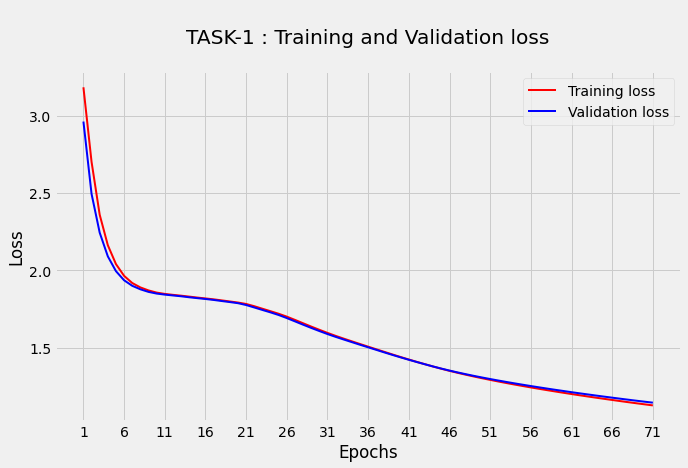

In [31]:
save_nd_plot_curve(task_1, 'TASK-1', 5, model_1, 'model_1')

In [32]:
def predict(input_sentence, model):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
    D. till we reach max_length of decoder or till the model predicted word <end>:
        predicted_out,state_h,state_c=model.layers[1](dec_input,states)
        pass the predicted_out to the dense layer
        update the states=[state_h,state_c]
        And get the index of the word with maximum probability of the dense layer output,
        using the tokenizer(word index) get the word and then store it in a string.
        Update the input_to_decoder with current predictions
    F. Return the predicted sentence
    '''
#     A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    encoder_inp = tknizer_ita.texts_to_sequences([input_sentence])
    encoder_inp_pad_seq = pad_sequences(encoder_inp, maxlen = 20, dtype = 'int32', padding = 'post')
    
#     B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    initial_stat = model.layers[0].initialize_states(1) # Batch size is 1, because we are only giving one at a time
    encoder_output, encoder_h, encoder_c  = model.layers[0](encoder_inp_pad_seq, initial_stat) # Encoder Layer
    
#     C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
    start_idx = tknizer_eng.word_index['<start>']
    end_idx = tknizer_eng.word_index['<end>']
    curr_vec = np.ones((1, 1))
    init_states = [encoder_h, encoder_c]
    
#     D. till we reach max_length of decoder or till the model predicted word <end>:

    predicted_string = []
    
    for idx in range(MAX_INPUT_LEN):
        
        predicted_out, state_h, state_c = model.layers[1](curr_vec, init_states) # Decoder Layer
        init_states = [state_h, state_c]
        predicted = model.layers[2](predicted_out) # Denes Layer
        predicted_index = np.argmax(predicted)

        if predicted_index == end_idx or predicted_index == 0:
            break

        predicted_string.append(tknizer_eng.index_word[predicted_index])

        curr_vec = np.reshape(predicted_index, (1, 1))
    
#     F. Return the predicted sentence
    return ' '.join(predicted_string)

In [33]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

validation_sampled = validation.sample(1000, random_state = 43)

def generate_predictoins(valid):
    
    g_truth, predicted_ressult = [], []
    
    for value in tqdm(valid.values):
        g_truth.append(re.sub(r'<\w*>', '', value[1]).strip())
        predicted_ressult.append(predict(value[0], model_1).strip())
        
    return g_truth, predicted_ressult
        
g_truth, predicted_ressult = generate_predictoins(validation_sampled)

100%|██████████| 1000/1000 [00:53<00:00, 18.86it/s]


In [34]:
avg_bleu_score = []
for g_t, p_r in zip(g_truth, predicted_ressult):
    avg_bleu_score.append(sentence_bleu([g_t], p_r))
    
print(f'Average Bleu Score :: {np.mean(avg_bleu_score)}')

Average Bleu Score :: 0.20797411217743747


## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [35]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        
        super().__init__()
        
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size

        # Initialize Embedding layer
        self.embeding = Embedding(input_dim = self.inp_vocab_size, output_dim = self.embedding_size, \
                      input_length = self.input_length, mask_zero = True, name = 'EmbeddingLayerEncoder')
        
        # Intialize Encoder LSTM layer
        self.lstm = LSTM(units = self.lstm_size, return_state = True, return_sequences = True, \
                                                                                    name = 'LSTM_Encoder')


    def call(self,input_sequence,states):
        
        '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
        returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        
        input_embeddings = self.embeding(input_sequence)
        self.encoder_output, self.encoder_last_state_h, self.encoder_last_state_c = \
                                                                                self.lstm(input_embeddings)
        
        return self.encoder_output, self.encoder_last_state_h, self.encoder_last_state_c
    
    def initialize_states(self,batch_size):
        
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units],
                                                                cell state zeros is of size [32,lstm_units]
        '''
        
        self.st_h = tf.zeros((batch_size, self.lstm_size))
        self.st_i = tf.zeros((batch_size, self.lstm_size))
        
        return self.st_h, self.st_i

<font color='cyan'>**Grader function - 1**</font>

In [36]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,\
                                                                               minval=0,dtype=tf.int32)
    
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and \
                        state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True

print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [37]:
class Attention(tf.keras.layers.Layer):
    '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self, scoring_function, att_units):
        super().__init__()
        
#     Please go through the reference notebook and research paper to complete the scoring functions
        self.scoring_function = scoring_function
        self.att_units = att_units

        if self.scoring_function == 'dot':
          # Intialize variables needed for Dot score function here
          pass

        if scoring_function == 'general':
            # Intialize variables needed for General score function here
            self.fc = Dense(units = self.att_units)
            
        elif scoring_function == 'concat':
            self.WE = Dense(units = self.att_units)
            self.WD = Dense(units = self.att_units)
            self.v = Dense(units = 1)
            # Intialize variables needed for Concat score function here
  
  
    def call(self, decoder_hidden_state, encoder_output):
        '''
        Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
        * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
        '''
    
        decoder_hidden_state = expand_dims(decoder_hidden_state, axis = 1)
        
        if self.scoring_function == 'dot':
            # Implement Dot score function here
            
            similarity_ =  Dot(axes = (2, 2))([encoder_output, decoder_hidden_state])
            
        elif self.scoring_function == 'general':
            # Implement General score function here
            
            weighted_encoder_out =  self.fc(encoder_output)  
            similarity_ = Dot(axes = (2, 2))([weighted_encoder_out, decoder_hidden_state])
            
        elif self.scoring_function == 'concat':
            # Implement General score function here
            
            weighted_encoder = self.WE(encoder_output)
            weighted_decoder = self.WD(decoder_hidden_state)
            tan_h_act = tanh(weighted_decoder + weighted_encoder)
            similarity_ = self.v(tan_h_act)
            
        attention_wt = softmax(similarity_, axis = 1)
        context_v =  attention_wt * encoder_output
        context_v = reduce_sum(context_v, axis = 1)
        return context_v, attention_wt

<font color='cyan'>**Grader function - 2**</font>

In [38]:
def grader_check_attention(scoring_fun):
    
    ''' 
    att_units: Used in matrix multiplications for scoring functions,
    input_length: Length of the input sentence,
    batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h = tf.random.uniform(shape = [batch_size, att_units])
    encoder_output = tf.random.uniform(shape = [batch_size, input_length, att_units])
    attention = Attention(scoring_fun, att_units)
    context_vector,attention_weights = attention(state_h, encoder_output)
    assert(context_vector.shape == (batch_size, att_units) and attention_weights.shape == \
                                                                       (batch_size, input_length, 1))
    
    return True

print(f"'dot'\t\t: {grader_check_attention('dot')}")
print(f"'general'\t: {grader_check_attention('general')}")
print(f"'concat'\t: {grader_check_attention('concat')}")

'dot'		: True
'general'	: True
'concat'	: True


<font color='blue'>**OneStepDecoder**</font>

In [39]:
class OneStepDecoder(tf.keras.Model):
    
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        #         Initialize decoder embedding layer, LSTM and any other objects needed
        
        super().__init__()
        self.tar_vocab_size = tar_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units

        self.embedding_layer = Embedding(input_dim = self.tar_vocab_size, output_dim = self.embedding_dim, \
                    mask_zero = True, input_length = self.input_length, name = 'Embedding_OneStepDecoder')
        
        self.lstm_1 = LSTM(units = self.dec_units, return_sequences = True, return_state = True, \
                                                                           name = 'LSTM_OneStepDecoder1')
        
        self.lstm_2 = LSTM(units = self.dec_units, return_sequences = True, return_state = True, \
                                                                           name = 'LSTM_OneStepDecoder2')
        
        
        self.attention = Attention(self.score_fun, self.att_units)
    
        self.fc = Dense(units = self.tar_vocab_size)
        
    def call(self, input_to_decoder, encoder_output, state_h,state_c):
        '''
        One step decoder mechanisim step by step:
        A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
        B. Using the encoder_output and decoder hidden state, compute the context vector.
        C. Concat the context vector with the step A output
        D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
        E. Pass the decoder output to dense layer(vocab size) and store the result into output.
        F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
#         A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size, 1, embedding_dim)
        output_embedding = self.embedding_layer(input_to_decoder)
        decoder_out, decoder_state_h, decoder_state_c = self.lstm_1(encoder_output, \
                                                                        initial_state = [state_h, state_c])
        
#         B. Using the encoder_output and decoder hidden state, compute the context vector.
        context_vec, attention_wt = self.attention(decoder_state_h, encoder_output)
    
#         C. Concat the context vector with the step A output
        combined_vec = tf.concat([expand_dims(context_vec, axis = 1), output_embedding], axis = -1)

#         D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
        decoder_out, decoder_h, decoder_c = self.lstm_2(combined_vec)

#         E. Pass the decoder output to dense layer(vocab size) and store the result into output.
        decoder_out = tf.reshape(decoder_out, (-1, decoder_out.shape[2]))
        output = self.fc(decoder_out)
        
#         F. Return the states from step D, output from Step E, attention weights from Step -B
        return output, decoder_h, decoder_c, attention_wt, context_vec

<font color='cyan'>**Grader function - 3**</font>

In [40]:
def grader_onestepdecoder(score_fun):
    
    '''
    tar_vocab_size: Unique words of the target language,
    embedding_dim: output embedding dimension for each word after embedding layer,
    dec_units: Number of lstm units in decoder,
    att_units: Used in matrix multiplications for scoring functions in attention class,
    input_length: Length of the target sentence,
    batch_size
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    
    onestepdecoder = OneStepDecoder(tar_vocab_size, embedding_dim, input_length, dec_units, \
                                                                                score_fun ,att_units)
    
    input_to_decoder = tf.random.uniform(shape = (batch_size, 1), maxval = 10, minval = 0, \
                                                                                     dtype = tf.int32)
    
    encoder_output = tf.random.uniform(shape = [batch_size, input_length, dec_units])
    state_h = tf.random.uniform(shape = [batch_size, dec_units])
    state_c = tf.random.uniform(shape = [batch_size, dec_units])
    output, state_h, state_c, attention_weights, context_vector = onestepdecoder(input_to_decoder, \
                                                                    encoder_output, state_h, state_c)
    
    assert(output.shape == (batch_size, tar_vocab_size))
    assert(state_h.shape == (batch_size, dec_units))
    assert(state_c.shape == (batch_size, dec_units))
    assert(attention_weights.shape == (batch_size, input_length,1))
    assert(context_vector.shape == (batch_size, dec_units))
    
    return True
    
print(f"'dot'\t\t: {grader_onestepdecoder('dot')}")
print(f"'general'\t: {grader_onestepdecoder('general')}")
print(f"'concat'\t: {grader_onestepdecoder('concat')}")

'dot'		: True
'general'	: True
'concat'	: True


<font color='blue'>**Decoder**</font>

In [41]:
class Decoder(tf.keras.Model):
    def __init__(self, out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
#       Intialize necessary variables and create an object from the class onestepdecoder

        self.out_vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units

        self.onestepdecoder = OneStepDecoder(tar_vocab_size = self.out_vocab_size, \
                                         embedding_dim = self.embedding_dim,
                                         input_length = self.input_length, dec_units = self.dec_units,
                                         score_fun = self.score_fun, att_units = self.att_units)
    
    def call(self, input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state ):

#         Initialize an empty Tensor array, that will store the outputs at each and every time step
#         Create a tensor array as shown in the reference notebook

        output_tf_arr = tf.TensorArray(tf.float32, size = self.input_length, name = 'Output_tf_array')
    
#         Iterate till the length of the decoder input
#             Call onestepdecoder for each token in decoder_input
#             Store the output in tensorarray
#         Return the tensor array
        
        for length in range(self.input_length):
            
            output, _, _, _, _ = self.onestepdecoder(input_to_decoder[:, length:length+1], \
                                            encoder_output, decoder_hidden_state, decoder_cell_state)
            
            output_tf_arr = output_tf_arr.write(length, output)
            
        output_tf_arr = tf.transpose(output_tf_arr.stack(),[1,0,2])
        
        return output_tf_arr
    

<font color='cyan'>**Grader function - 4**</font>

In [42]:
def grader_decoder(score_fun):
    
    '''
    out_vocab_size: Unique words of the target language,
    embedding_dim: output embedding dimension for each word after embedding layer,
    dec_units: Number of lstm units in decoder,
    att_units: Used in matrix multiplications for scoring functions in attention class,
    input_length: Length of the target sentence,
    batch_size
    '''
    
    out_vocab_size = 13 
    embedding_dim = 12 
    input_length = 11
    dec_units = 16 
    att_units = 16
    batch_size = 32
    
    target_sentences = tf.random.uniform(shape = (batch_size, input_length), maxval = 10, \
                                                                        minval = 0, dtype = tf.int32)
    
    encoder_output = tf.random.uniform(shape = [batch_size, input_length, dec_units])
    state_h = tf.random.uniform(shape = [batch_size, dec_units])
    state_c = tf.random.uniform(shape = [batch_size, dec_units])
    
    decoder = Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output = decoder(target_sentences, encoder_output, state_h, state_c)
    assert(output.shape == (batch_size, input_length, out_vocab_size))
    
    return True

print(f"'dot'\t\t: {grader_decoder('dot')}")
print(f"'general'\t: {grader_decoder('general')}")
print(f"'concat'\t: {grader_decoder('concat')}")

'dot'		: True
'general'	: True
'concat'	: True


<font color='blue'>**Encoder Decoder model**</font>

In [43]:
class encoder_decoder(tf.keras.Model):
    
    def __init__(self, enc_vocab_size, dec_vocab_size, en_embedding_size, dec_embedding_size, \
                         en_lstm_size, de_lstm_size, en_input_length, de_input_length, score_fun, \
                         att_units, batch_size):
        
        super().__init__()
        self.batch_size = batch_size
        
#     Intialize objects from encoder decoder

        self.encoder = Encoder(inp_vocab_size = enc_vocab_size, embedding_size = en_embedding_size, \
                                           lstm_size = en_lstm_size, input_length = en_embedding_size)
    
        self.decoder = Decoder(out_vocab_size = dec_vocab_size, embedding_dim = dec_embedding_size, \
                                           input_length = de_input_length, dec_units = de_lstm_size, \
                                           score_fun = score_fun ,att_units = att_units)

    def call(self, data):

#     Intialize encoder states, Pass the encoder_sequence to the embedding layer
        encoder_input, decoder_input = data[0], data[1]
        en_out, en_h, en_c = self.encoder(encoder_input, self.encoder.initialize_states(self.batch_size))
        
#     Decoder initial states are encoder final states, Initialize it accordingly
        dec_h = en_h
        dec_c = en_c
        decoder_out = self.decoder(decoder_input, en_out, dec_h, dec_c)
        
#     return the decoder output
        return decoder_out

<font color='blue'>**Custom loss function**</font>

In [44]:
# https://www.tensorflow.org/tutorials/text/image_captioning#model

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

def loss_function(real, pred):
    
    """
    Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.
    """
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype = loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

Implement dot function here.

In [45]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.


EPOCH = 51
BATCH_SIZE = 512
MAX_INPUT_LEN = 20

train_dataset = Dataset(train, tknizer_ita, tknizer_eng, MAX_INPUT_LEN)

test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, MAX_INPUT_LEN)



train_dataloader = Dataloder(train_dataset, batch_size = BATCH_SIZE)
test_dataloader = Dataloder(test_dataset, batch_size = BATCH_SIZE)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(512, 20) (512, 20) (512, 20)


In [46]:
tf.keras.backend.clear_session()

model_2_dot = encoder_decoder(enc_vocab_size = vocab_size_ita + 1, dec_vocab_size = vocab_size_eng + 1,
                en_embedding_size = 100, dec_embedding_size = 100,
                en_lstm_size = 256, de_lstm_size = 256,
                en_input_length = MAX_INPUT_LEN, de_input_length = MAX_INPUT_LEN,
                score_fun = 'dot', att_units = 256, batch_size = BATCH_SIZE)

In [47]:
# Compile the model and fit the model

model_2_dot.compile(optimizer_, loss = loss_function)

train_steps = train.shape[0]//BATCH_SIZE
valid_steps = validation.shape[0]//BATCH_SIZE

tensorBord = call_back_tBoard('logs_dot')

task_2_dot = model_2_dot.fit(x = train_dataloader, validation_data = test_dataloader, \
                    epochs = EPOCH, steps_per_epoch = train_steps, validation_steps = valid_steps,
                    callbacks = [tensorBord])

Epoch 1/51
559/559 [==============================] - 277s 336ms/step - loss: 1.9764 - val_loss: 1.7917
Epoch 2/51
559/559 [==============================] - 155s 277ms/step - loss: 1.7538 - val_loss: 1.7251
Epoch 3/51
559/559 [==============================] - 154s 275ms/step - loss: 1.7070 - val_loss: 1.6835
Epoch 4/51
559/559 [==============================] - 154s 275ms/step - loss: 1.6605 - val_loss: 1.6372
Epoch 5/51
559/559 [==============================] - 154s 275ms/step - loss: 1.6192 - val_loss: 1.6016
Epoch 6/51
559/559 [==============================] - 153s 274ms/step - loss: 1.5851 - val_loss: 1.5691
Epoch 7/51
559/559 [==============================] - 154s 276ms/step - loss: 1.5501 - val_loss: 1.5322
Epoch 8/51
559/559 [==============================] - 153s 274ms/step - loss: 1.5089 - val_loss: 1.4870
Epoch 9/51
559/559 [==============================] - 154s 276ms/step - loss: 1.4605 - val_loss: 1.4405
Epoch 10/51
559/559 [==============================] - 154s 276m

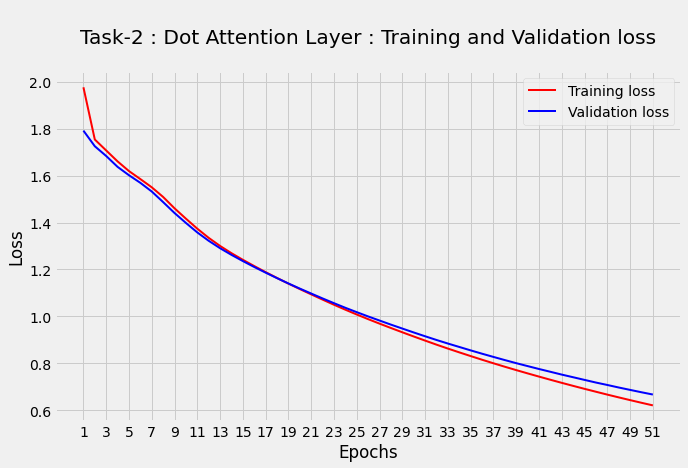

In [48]:
save_nd_plot_curve(task_2_dot, 'Task-2 : Dot Attention Layer', 2, model_2_dot, 'model_2_dot')

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [49]:
# Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate

def plot_attention(sentence, model):
    
    pred_, input_sentence, attention_wt = predict(sentence, model)
    print(f'Input :: {input_sentence:>50}')
    print(f'Predicted translation :: {pred_:>16}\n')
    
    attention_wt = attention_wt[:len(pred_.split()), :len(input_sentence.split())]
    
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cax = ax.matshow(attention_wt, cmap = 'viridis')

    fig.colorbar(cax)
    fontdict = {'fontsize': 12}
    
    imputs = input_sentence.split()
    preds_ = pred_.split()

    ax.set_xticklabels([''] + imputs, fontdict = fontdict, rotation = 90)
    ax.set_yticklabels([''] + preds_, fontdict = fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')

    plt.show()

<font color='blue'>**Predict the sentence translation**</font>

In [50]:
def predict(input_sentence, model):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
#     A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    encoder_inp = tknizer_ita.texts_to_sequences([input_sentence])
    encoder_inp_pad_seq = pad_sequences(encoder_inp, maxlen = 20, dtype = 'int32', padding = 'post')

#     B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    initial_stat = model.layers[0].initialize_states(1) # Batch size is 1, because we are only giving one at a time
    encoder_output, encoder_h, encoder_c  = model.layers[0](encoder_inp_pad_seq, initial_stat) # Encoder Layer
    
#     C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    curr_vec = np.array(tknizer_eng.word_index['<start>']).reshape(1,1)
    end_idx = tknizer_eng.word_index['<end>']
    
    attention_plot = np.zeros((20, 20))
    
#     D. till we reach max_length of decoder or till the model predicted word <end>:

    predicted_string = []
    
    for idx in range(MAX_INPUT_LEN):
        
        output, state_h, state_c, attention_weights, context_vector = \
                        model.layers[1].onestepdecoder(curr_vec, encoder_output, encoder_h, encoder_c)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[idx] = attention_weights.numpy()
        
        predicted_index = np.argmax(output)
        predicted_string.append(tknizer_eng.index_word[predicted_index])

        if predicted_index == end_idx or predicted_index == 0:
            break

        curr_vec = np.reshape(predicted_index, (1, 1))
    
#     F. Return the predicted sentence
    return ' '.join(predicted_string), input_sentence, attention_plot

In [51]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

# validation_sampled = validation.sample(1000, random_state = 43)

def generate_attention_predictoins(valid, model):
    
    g_truth, predicted_ressult = [], []
    
    for value in tqdm(valid.values):
        g_truth.append(re.sub(r'<\w*>', '', value[1]).strip())
        pred_, input_sentence, attention_wt = predict(value[0], model)
        
        predicted_ressult.append(pred_)
        
    return g_truth, predicted_ressult
        
g_truth, predicted_ressult = generate_attention_predictoins(validation_sampled, model_2_dot)

100%|██████████| 1000/1000 [01:40<00:00,  9.92it/s]


<font color='blue'>**Calculate BLEU score**</font>

In [52]:
## Create an object of your custom model.
## Compile and train your model on dot scoring function.
##  Visualize few sentences randomly in Test data
## Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
## https://www.nltk.org/_modules/nltk/translate/bleu_score.html

## Sample example
# import nltk.translate.bleu_score as bleu
# reference = ['i am groot'.split(),] # the original
# translation = 'it is ship'.split() # trasilated using model
# print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))


avg_bleu_score_att = []
for g_t, p_r in zip(g_truth, predicted_ressult):
    avg_bleu_score_att.append(sentence_bleu([g_t], p_r))
    
print(f'Average Bleu Score :: {np.mean(avg_bleu_score_att)}')

Average Bleu Score :: 0.33556081287880274


Input ::            molta gente è stata uccisa nella guerra
Predicted translation :: many people were killed in the war <end>



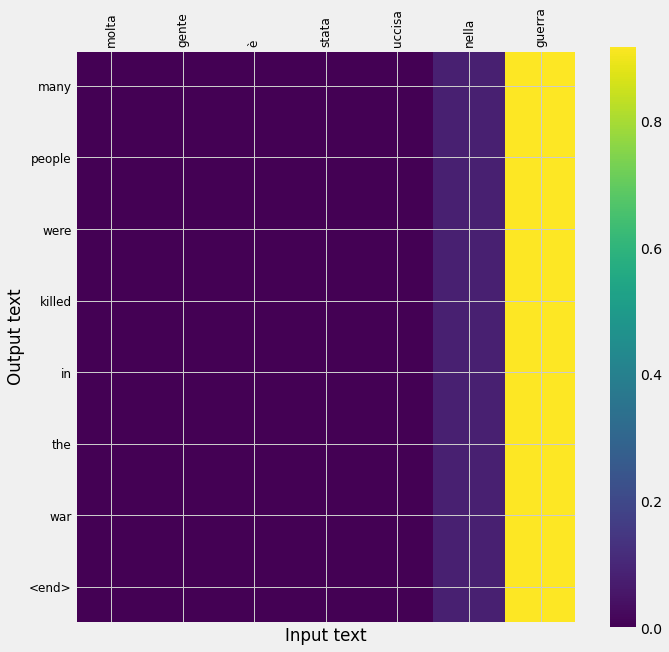

In [53]:
plot_attention('molta gente è stata uccisa nella guerra', model_2_dot)

Input ::                         mary non ama il suo marito
Predicted translation :: mary is not love his girlfriend <end>



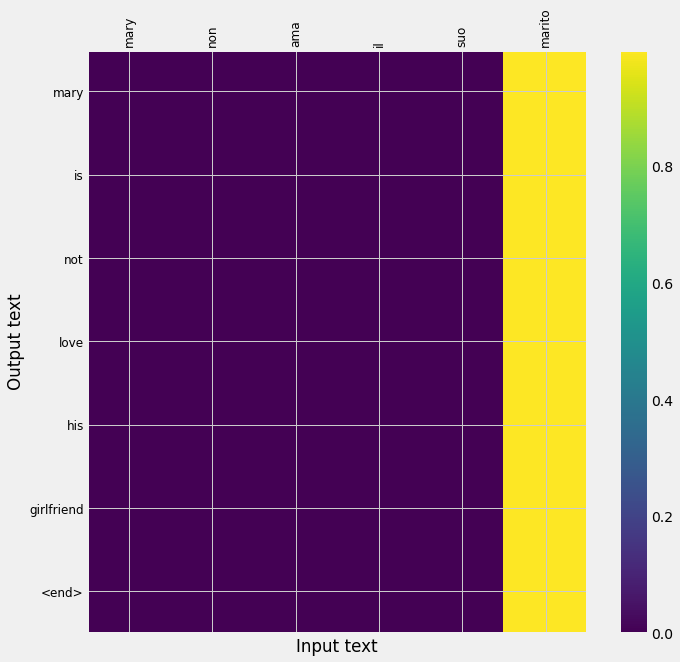

In [54]:
plot_attention('mary non ama il suo marito', model_2_dot)

Input ::                               non puoi sposare tom
Predicted translation :: you can not you can not you can not you can not you can not you can not you can



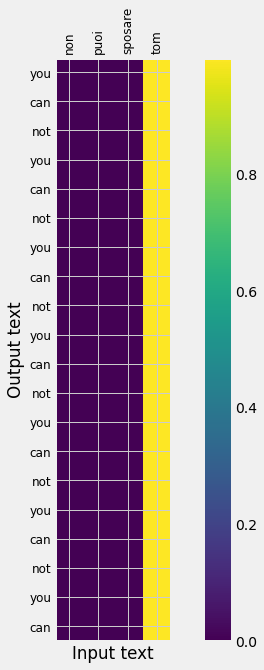

In [55]:
plot_attention('non puoi sposare tom', model_2_dot)

<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [56]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html


model_2_general = encoder_decoder(enc_vocab_size = vocab_size_ita + 1,
                dec_vocab_size = vocab_size_eng + 1,
                en_embedding_size = 100, dec_embedding_size = 100,
                en_lstm_size = 256, de_lstm_size = 256,
                en_input_length = MAX_INPUT_LEN, de_input_length = MAX_INPUT_LEN,
                score_fun = 'general', att_units = 256, batch_size = BATCH_SIZE)

# Compile the model and fit the model

model_2_general.compile(optimizer_, loss = loss_function)

train_steps = train.shape[0]//BATCH_SIZE
valid_steps = validation.shape[0]//BATCH_SIZE

tensorBord = call_back_tBoard('logs_general')

task_2_general = model_2_general.fit(x = train_dataloader, validation_data = test_dataloader, \
                    epochs = EPOCH, steps_per_epoch = train_steps, validation_steps = valid_steps,
                    callbacks = [tensorBord])

Epoch 1/51
559/559 [==============================] - 292s 355ms/step - loss: 1.9827 - val_loss: 1.8112
Epoch 2/51
559/559 [==============================] - 162s 290ms/step - loss: 1.7601 - val_loss: 1.7205
Epoch 3/51
559/559 [==============================] - 162s 289ms/step - loss: 1.6983 - val_loss: 1.6776
Epoch 4/51
559/559 [==============================] - 163s 291ms/step - loss: 1.6650 - val_loss: 1.6521
Epoch 5/51
559/559 [==============================] - 162s 290ms/step - loss: 1.6424 - val_loss: 1.6321
Epoch 6/51
559/559 [==============================] - 162s 291ms/step - loss: 1.6215 - val_loss: 1.6097
Epoch 7/51
559/559 [==============================] - 163s 292ms/step - loss: 1.5935 - val_loss: 1.5771
Epoch 8/51
559/559 [==============================] - 163s 291ms/step - loss: 1.5597 - val_loss: 1.5452
Epoch 9/51
559/559 [==============================] - 163s 291ms/step - loss: 1.5276 - val_loss: 1.5099
Epoch 10/51
559/559 [==============================] - 163s 292m

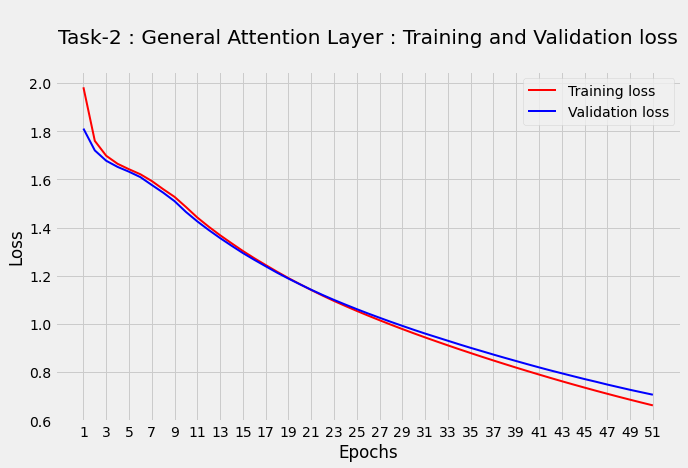

In [57]:
save_nd_plot_curve(task_2_general, 'Task-2 : General Attention Layer', 2, model_2_general, \
                                                                                   'model_2_general')

In [58]:
g_truth, predicted_ressult = generate_attention_predictoins(validation_sampled, model_2_general)

100%|██████████| 1000/1000 [01:53<00:00,  8.77it/s]


In [59]:
avg_bleu_score_att = []
for g_t, p_r in zip(g_truth, predicted_ressult):
    avg_bleu_score_att.append(sentence_bleu([g_t], p_r))
    
print(f'Average Bleu Score :: {np.mean(avg_bleu_score_att)}')

Average Bleu Score :: 0.3088731001455924


Input ::            molta gente è stata uccisa nella guerra
Predicted translation ::    the war <end>



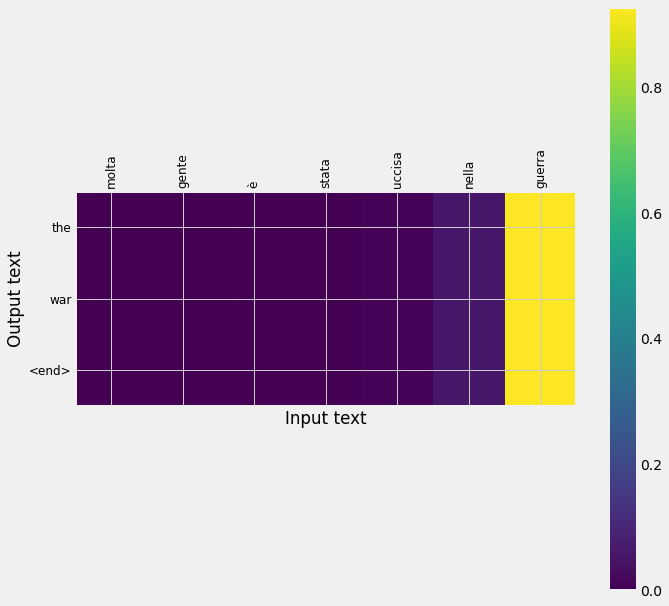

In [60]:
plot_attention('molta gente è stata uccisa nella guerra', model_2_general)

Input ::                         mary non ama il suo marito
Predicted translation :: mary does not his name <end>



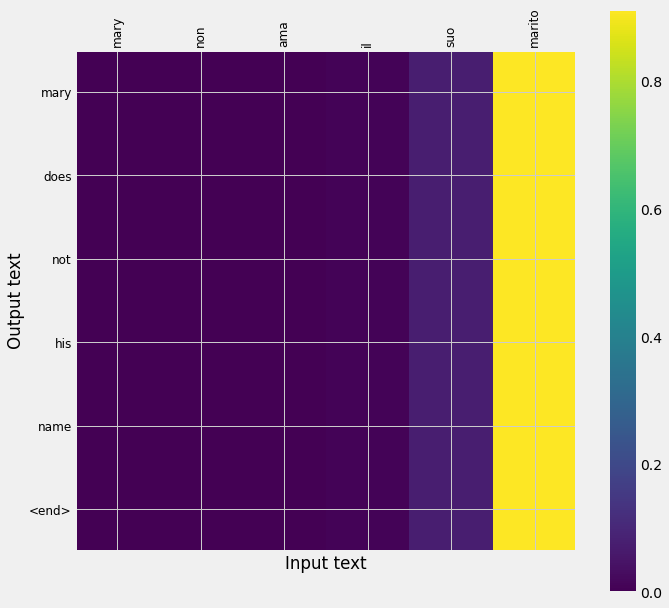

In [61]:
plot_attention('mary non ama il suo marito', model_2_general)

Input ::                               non puoi sposare tom
Predicted translation :: you can not you can not you can not you can not you can not you can not you can



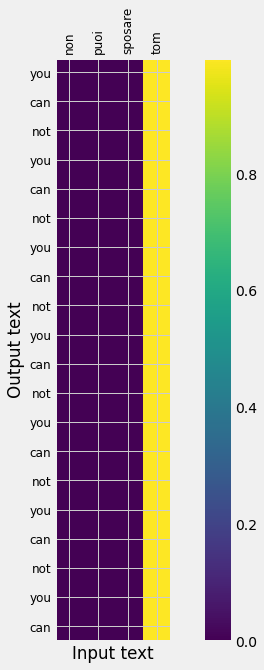

In [62]:
plot_attention('non puoi sposare tom', model_2_general)

<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [63]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

model_2_concat = encoder_decoder(enc_vocab_size = vocab_size_ita + 1, dec_vocab_size = vocab_size_eng + 1,
                en_embedding_size = 100, dec_embedding_size = 100,
                en_lstm_size = 256, de_lstm_size = 256,
                en_input_length = MAX_INPUT_LEN, de_input_length = MAX_INPUT_LEN,
                score_fun = 'concat', att_units = 256, batch_size = BATCH_SIZE)

# Compile the model and fit the model

model_2_concat.compile(optimizer_, loss = loss_function)

train_steps = train.shape[0]//BATCH_SIZE
valid_steps = validation.shape[0]//BATCH_SIZE

tensorBord = call_back_tBoard('logs_concat')

task_2_concat = model_2_concat.fit(x = train_dataloader, validation_data = test_dataloader, \
                   epochs = EPOCH, steps_per_epoch = train_steps, validation_steps = valid_steps,
                   callbacks = [tensorBord])

Epoch 1/51
559/559 [==============================] - 305s 378ms/step - loss: 1.9638 - val_loss: 1.8018
Epoch 2/51
559/559 [==============================] - 173s 310ms/step - loss: 1.7209 - val_loss: 1.6993
Epoch 3/51
559/559 [==============================] - 172s 307ms/step - loss: 1.6443 - val_loss: 1.6320
Epoch 4/51
559/559 [==============================] - 172s 308ms/step - loss: 1.5920 - val_loss: 1.5914
Epoch 5/51
559/559 [==============================] - 171s 307ms/step - loss: 1.5455 - val_loss: 1.5439
Epoch 6/51
559/559 [==============================] - 172s 307ms/step - loss: 1.4979 - val_loss: 1.5036
Epoch 7/51
559/559 [==============================] - 172s 308ms/step - loss: 1.4608 - val_loss: 1.4757
Epoch 8/51
559/559 [==============================] - 172s 308ms/step - loss: 1.4323 - val_loss: 1.4495
Epoch 9/51
559/559 [==============================] - 172s 308ms/step - loss: 1.4034 - val_loss: 1.4106
Epoch 10/51
559/559 [==============================] - 174s 311m

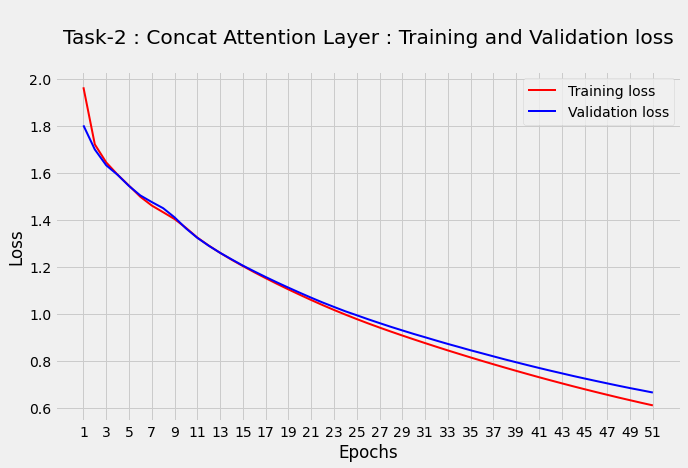

In [64]:
save_nd_plot_curve(task_2_concat, 'Task-2 : Concat Attention Layer', 2, \
                                                               model_2_concat, 'model_2_concat')

In [65]:
g_truth, predicted_ressult = generate_attention_predictoins(validation_sampled, model_2_concat)

100%|██████████| 1000/1000 [01:48<00:00,  9.25it/s]


In [66]:
avg_bleu_score_att = []
for g_t, p_r in zip(g_truth, predicted_ressult):
    avg_bleu_score_att.append(sentence_bleu([g_t], p_r))
    
print(f'Average Bleu Score :: {np.mean(avg_bleu_score_att)}')

Average Bleu Score :: 0.33176164376840245


Input ::            molta gente è stata uccisa nella guerra
Predicted translation :: many people were a lot of people were a lot of people were a lot of people were a lot



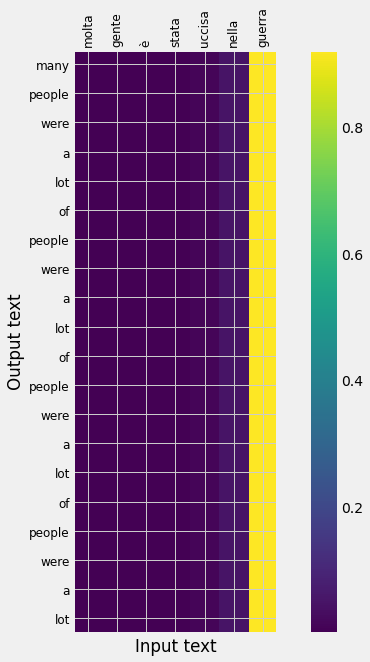

In [67]:
plot_attention('molta gente è stata uccisa nella guerra', model_2_concat)

Input ::                         mary non ama il suo marito
Predicted translation :: mary is his father <end>



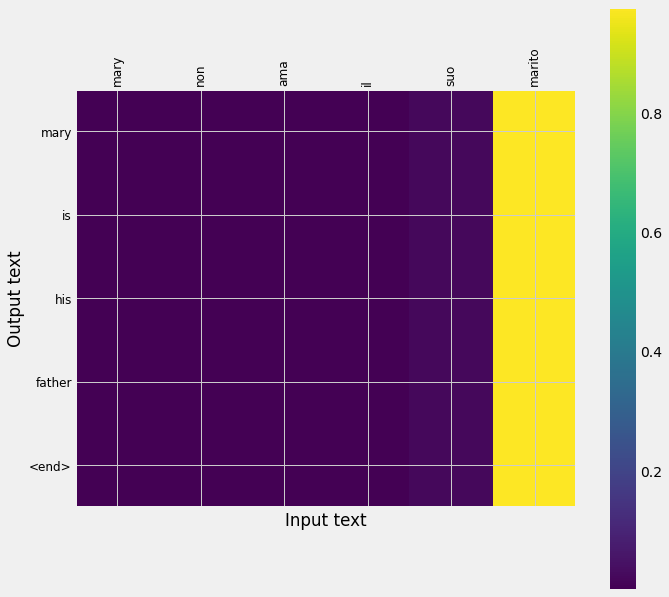

In [68]:
plot_attention('mary non ama il suo marito', model_2_concat)

Input ::                               non puoi sposare tom
Predicted translation :: you can not you can not you can not you can not you can not you can not you can



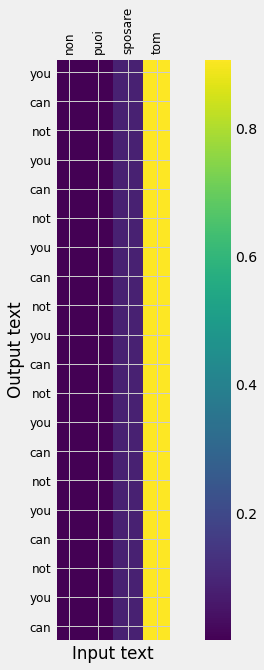

In [69]:
plot_attention('non puoi sposare tom', model_2_concat)

References
- https://www.kaggle.com/code/nageshsingh/neural-machine-translation/notebook
- https://github.com/edumunozsala/NMT-encoder-decoder-Attention/blob/main/Intro-seq2seq-Encoder-Decoder-ENG-SPA-translator-tf2.ipynb
- https://blog.paperspace.com/nlp-machine-translation-with-keras/
- https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
- https://notebook.community/JannesKlaas/MLiFC/Week%205/Ch.%2020%20-%20Seq2Seq%20Translation
- https://nextjournal.com/gkoehler/machine-translation-seq2seq-cpu
- https://www.kaggle.com/code/chiragtagadiya/attention-paper-nmt-italian-to-eng-translation
- https://www.kaggle.com/code/chiragtagadiya/nmt-tutorial#Attention-plot-for-some-random-input-(concat-input)